In [ ]:
#-*- coding: utf-8 -*-
#!wget -q https://i3.ruliweb.com/img/23/07/03/1891bd297fb1370f8.png -o input.jpg
#!wget -q https://github.com/kairess/toy-datasets/raw/master/NanumSquareNeo-Variable.ttf

FILE_NAME = "input.jpg"
FONT_PATH = "NanumSquareNeo-Variable.ttf"



from PIL import Image
img = Image.open(FILE_NAME)
#img

: 

In [1]:
import cv2
from tkinter import *

root = Tk()
x = 0
y = 0
#monitor_height = root.winfo_screenheight()
#monitor_width = root.winfo_screenwidth()
monitor_height = 300
monitor_width = 300

def onChange(x):
  pass

#video controller
#cv2컨트롤러 : S
cv2.namedWindow('detection')
cv2.createTrackbar('x threshold', 'detection', 0, monitor_width, onChange)
cv2.setTrackbarMin('x threshold', 'detection', 0)
cv2.createTrackbar('y threshold', 'detection', 0, monitor_height, onChange)
cv2.setTrackbarMin('y threshold', 'detection', 0)
cv2.createTrackbar('width threshold', 'detection', 0, monitor_width, onChange)
cv2.setTrackbarMin('width threshold', 'detection', monitor_width)
cv2.createTrackbar('height threshold', 'detection', 0, monitor_height, onChange)
cv2.setTrackbarMin('height threshold', 'detection', monitor_height)
#cv2컨트롤러 : E

import time
import pyautogui
import numpy as np # numpy 패키지 로드하여 np로 사용
while True:
  
  #캐니 엣지 값
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

  im = pyautogui.screenshot(region=(x, y, monitor_width, monitor_height))
  gray = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2GRAY)

  cv2.imshow("detection", gray)
  time.sleep(5)
cv2.destroyAllWindows()

In [ ]:
#ocr원본 언어 설정
from paddleocr import PaddleOCR, draw_ocr

#원본 언어 설정 한국어 korean
ocr = PaddleOCR(lang="en")

[2023/07/05 16:11:03] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\siwon/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\siwon/.paddleocr/whl\\rec\\en\\en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, re

In [ ]:
#ocr 리더로 이미지 파일의 내용 인식 및 위치 정보 가져오기
img_path = FILE_NAME

result = ocr.ocr(img_path, cls=False) #cls 는 글자가 회전 되어 있을 때 인식 하는 것 설정

#for r in result[0]:
#    print(r)

[2023/07/05 16:11:08] ppocr DEBUG: dt_boxes num : 12, elapse : 0.4807777404785156
[2023/07/05 16:11:09] ppocr DEBUG: rec_res num  : 12, elapse : 1.7946264743804932


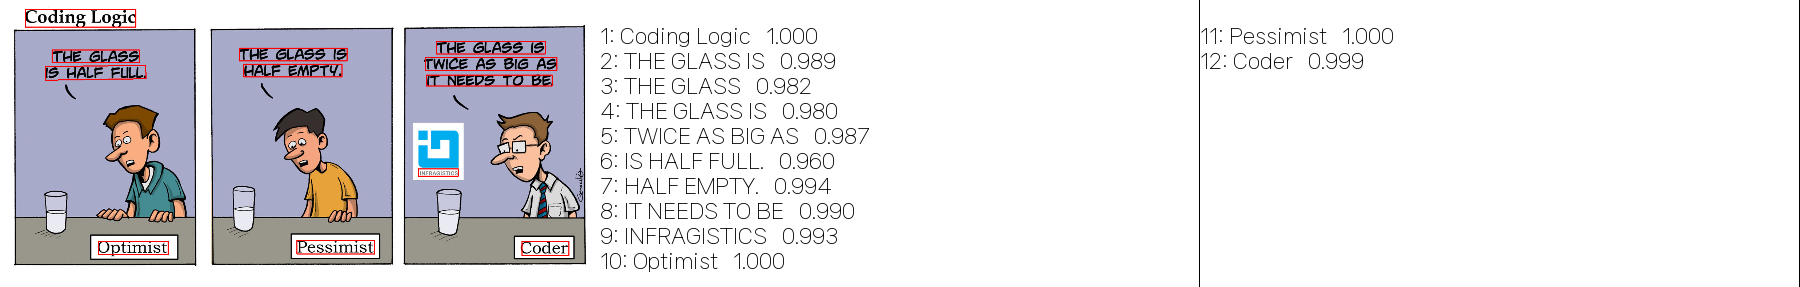

In [ ]:
#값을 입력 하고 
boxes  = []
txts = []
scores = []
for line in result[0]:
    boxes.append(line[0])
    txts.append(line[1][0])
    scores.append(line[1][1])

#boxes = [line[0] for line in result[0]]
#txts = [line[1][0] for line in result[0]]
#scores = [line[1][1] for line in result[0]]

result_np = draw_ocr(img, boxes, txts, scores, font_path=FONT_PATH)
result_img = Image.fromarray(result_np)

result_img

In [ ]:
boxes = []
for i, r in enumerate(result[0]):
    x1, y1 = r[0][0]
    x2, y2 = r[0][2]
    w, h = x2 - x1, y2 - y1

    text, conf = r [1]

    boxes.append([int(x1), int(y1), int(w), int(h), text, conf, i])

#boxes

In [ ]:
# Cluster bounding boxes w/ChatGPT
#https://chat.openai.com/share/de7cadbb-2ae8-4aeb-b083-9d9d28a50350
#pip install scikit-learn
import numpy as np
from sklearn.cluster import DBSCAN

def calculate_center(box):
    # box format: [x, y, w, h]
    center_x = box[0] + box[2] / 2
    center_y = box[1] + box[3] / 2
    return np.array([center_x, center_y])

def cluster_boxes(boxes, eps):
    #eps 입실론 주변 영역 반경
    #min_samples 핵심 포인트가 되기 위해서 입실론 주변 영역내에 포함되어야 할 데이터의 최소

    # Calculate centers
    centers = np.array([calculate_center(box) for box in boxes])
    
    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=1).fit(centers)
    labels = clustering.labels_
    
    # Group boxes by cluster
    clusters = {}
    for i, label in enumerate(labels):
        if label in clusters:
            clusters[label].append(i)
        else:
            clusters[label] = [i]

    return list(clusters.values())

In [ ]:
clusters = cluster_boxes(boxes, 100)

clusters

[[0], [1, 4, 7], [2, 5], [3, 6], [8], [9], [10], [11]]

In [ ]:
ocr_result = []

for c in clusters:
    sub_result = []

    for i, box in enumerate(boxes):
        if i in c:
            sub_result.append(box)

    ocr_result.append(sub_result)

ocr_result

[[[69, 25, 304, 49, 'Coding Logic', 0.9998050332069397, 0]],
 [[1200, 113, 299, 35, 'THE GLASS IS', 0.9885744452476501, 1],
  [1169, 158, 362, 35, 'TWICE AS BIG AS', 0.9867455363273621, 4],
  [1172, 206, 346, 30, 'IT NEEDS TO BE', 0.9896587133407593, 7]],
 [[143, 137, 240, 35, 'THE GLASS', 0.9823113679885864, 2],
  [124, 183, 277, 33, 'IS HALF FULL.', 0.9603691101074219, 5]],
 [[658, 132, 296, 35, 'THE GLASS IS', 0.9796895980834961, 3],
  [670, 176, 270, 35, 'HALF EMPTY.', 0.9942780137062073, 6]],
 [[1150, 464, 110, 20, 'INFRAGISTICS', 0.9926548004150391, 8]],
 [[270, 663, 192, 37, 'Optimist', 0.9997565746307373, 9]],
 [[816, 661, 214, 37, 'Pessimist', 0.9995930790901184, 10]],
 [[1435, 663, 129, 39, 'Coder', 0.9994297027587891, 11]]]

In [ ]:
final_result = []

for sub_result in ocr_result:
    x1 = sub_result[0][0]
    y1 = sub_result[0][1]
    x2 = sub_result[-1][0] + sub_result[-1][2]
    y2 = sub_result[-1][1] + sub_result[-1][3]

    w, h = x2 - x1, y2 - y1

    text = ""

    for r in sub_result:
        text += r[4] + " "
    
    text = text.strip()

    final_result.append([x1, y1, w, h, text])

final_result

[[69, 25, 304, 49, 'Coding Logic'],
 [1200, 113, 318, 123, 'THE GLASS IS TWICE AS BIG AS IT NEEDS TO BE'],
 [143, 137, 258, 79, 'THE GLASS IS HALF FULL.'],
 [658, 132, 282, 79, 'THE GLASS IS HALF EMPTY.'],
 [1150, 464, 110, 20, 'INFRAGISTICS'],
 [270, 663, 192, 37, 'Optimist'],
 [816, 661, 214, 37, 'Pessimist'],
 [1435, 663, 129, 39, 'Coder']]

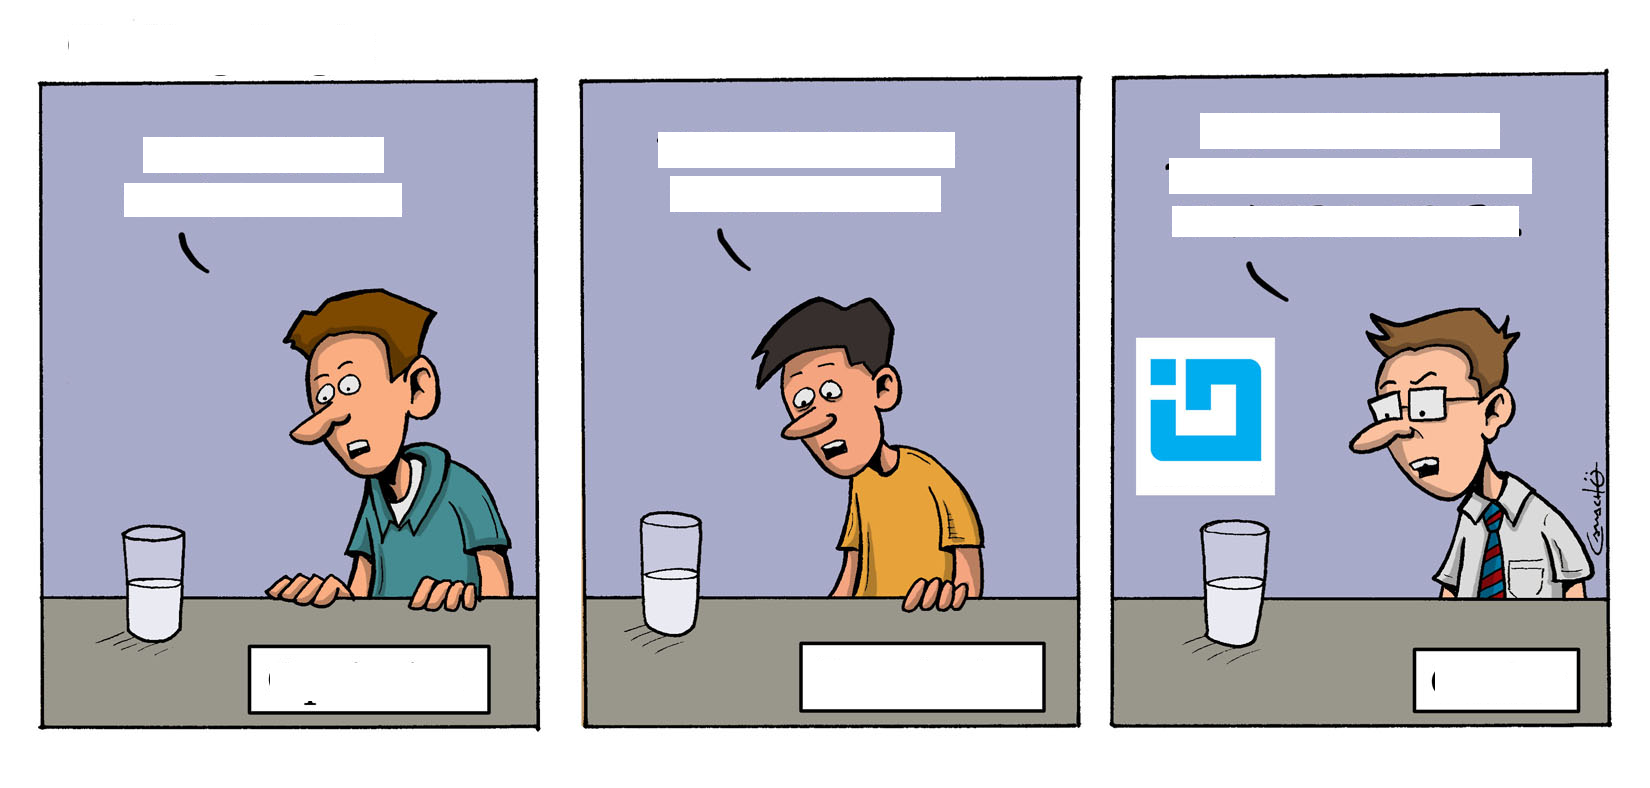

In [ ]:
#이미지에서 한글 지우기
from PIL import Image, ImageDraw

#point = (50, 50, 150, 150)  # 박스 좌표 (왼쪽 상단 x, 왼쪽 상단 y, 오른쪽 하단 x, 오른쪽 하단 y)
def draw_white(img, point):
    draw = ImageDraw.Draw(img)    
    draw.rectangle(point, outline='white', fill='white')

for box in boxes:
    draw_white(img, [box[0], box[1], box[0] + box[2], box[1] + box[3]])
img



In [ ]:
#pip install translate
from translate import Translator

translator = Translator(from_lang="en", to_lang="ko")

for i, r in enumerate(final_result):
    text_en = translator.translate(r[4])

    final_result[i].append(text_en.upper())

final_result

[[69, 25, 304, 49, 'Coding Logic', '코딩 로직'],
 [1200,
  113,
  318,
  123,
  'THE GLASS IS TWICE AS BIG AS IT NEEDS TO BE',
  '유리잔은 필요한 것보다 두 배 더 큽니다.'],
 [143, 137, 258, 79, 'THE GLASS IS HALF FULL.', '잔이 절반 가득 찼습니다.'],
 [658, 132, 282, 79, 'THE GLASS IS HALF EMPTY.', '유리가 반쯤 비어 있습니다.'],
 [1150, 464, 110, 20, 'INFRAGISTICS', 'INFRAGISTICS'],
 [270, 663, 192, 37, 'Optimist', '긍정주의자'],
 [816, 661, 214, 37, 'Pessimist', '염세주의'],
 [1435, 663, 129, 39, 'Coder', '프로그래머']]

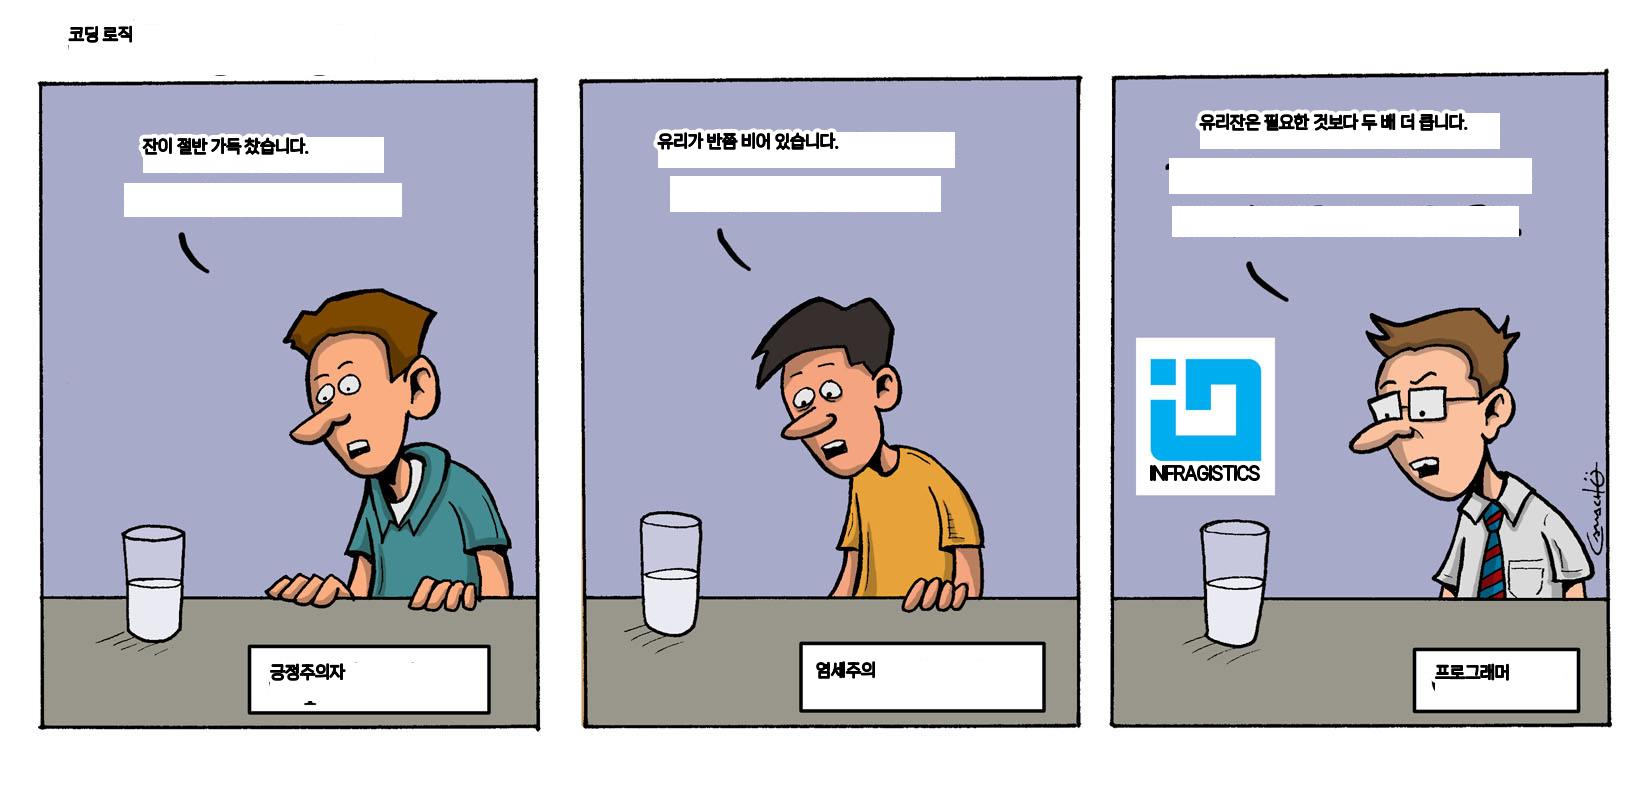

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

result_img2 = img.copy()

draw = ImageDraw.Draw(result_img2)

for r in final_result:
    x1, y1, w, h, text_ko, text_en = r

    text_position = (x1, y1)

    font = ImageFont.truetype(FONT_PATH, 16)
    wrapped_text = textwrap.wrap(text_en, width=w/8)

    line_height = font.getsize("hg")[1] * 1.5
    for line in wrapped_text:
        draw.text(text_position, line, fill="black", font=font, stroke_width=5, stroke_fill="white")
        draw.text(text_position, line, fill="black", font=font, stroke_width=1, stroke_fill="black")
        text_position = (text_position[0], text_position[1] + line_height)

result_img2